# Práctica 7: Detectar y Corregir Sesgo con Fairlearn

## UT2: Calidad & Ética | Práctica Interactiva - Dos Casos de Estudio

### 🎯 Objetivos de Aprendizaje¶

- DETECTAR sesgo histórico en datasets reales (Boston Housing + Titanic)
- ANALIZAR impacto del sesgo en predicciones de modelos
- COMPARAR estrategias: detección (regresión) vs corrección (clasificación)
- EVALUAR cuándo detectar vs cuándo intentar corregir automáticamente
- DESARROLLAR criterios éticos para deployment responsable

## 🧩 Flujo de la Práctica Completa

### 📊 Parte I - Boston Housing: DETECTAR Sesgo Histórico

- Analizar sesgo oculto en variable 'B' (proporción afroamericana)
- Cuantificar impacto del sesgo en predicciones (regresión)
- Analizar correlaciones y distribuciones por grupos raciales
- NO corregir - enfoque en detección y análisis 

### 🚢 Parte II - Titanic: DETECTAR + CORREGIR Sesgo Sistemático

- Detectar sesgo género/clase en protocolo "Women and Children First"
- Analizar interseccionalidad (género × clase social) 
- Aplicar Fairlearn para corrección (clasificación natural)

### 🔧 Parte III - Aplicar en Ames Housing

In [ ]:
# !pip install fairlearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

# Fairlearn - La estrella del show
from fairlearn.metrics import (
    MetricFrame, 
    demographic_parity_difference, 
    equalized_odds_difference,
    selection_rate
)
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("⚖️ PRÁCTICA 7: Detectar y Corregir Sesgo con Fairlearn")
print("📊 Parte I: Boston Housing (sesgo racial histórico)")
print("🚢 Parte II: Titanic (sesgo género + clase)")
print("🔧 Parte III: Pipeline automático producción")

⚖️ PRÁCTICA 7: Detectar y Corregir Sesgo con Fairlearn
📊 Parte I: Boston Housing (sesgo racial histórico)
🚢 Parte II: Titanic (sesgo género + clase)
🔧 Parte III: Pipeline automático producción


## 📊 PARTE I - BOSTON HOUSING: SESGO RACIAL HISTÓRICO¶

### 🔄 Paso 1: Cargar Boston desde Fuente Original

- ¿Por qué sklearn removió load_boston()? --> Sesgo racial explícito en variable 'B'.

In [2]:
# Cargar desde fuente original (CMU)
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Restructurar formato especial
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

print(f"✅ Boston Housing cargado: {data.shape}")

✅ Boston Housing cargado: (506, 13)


## 🔄 Paso 2: Crear DataFrame con Variable Problemática

In [3]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
                'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

boston_df = pd.DataFrame(data, columns=feature_names)
boston_df['MEDV'] = target

# Decodificar variable B problemática
# B = 1000(Bk - 0.63)² → Bk = sqrt(B/1000) + 0.63
boston_df['Bk_racial'] = np.sqrt(boston_df['B'] / 1000) + 0.63

print(f"🚨 Variable B (racial): correlación = {boston_df['B'].corr(boston_df['MEDV']):.3f}")
print(f"📊 Proporción racial media: {boston_df['Bk_racial'].mean():.3f}")

🚨 Variable B (racial): correlación = 0.333
📊 Proporción racial media: 1.216


## 🔄 Paso 3: Modelo Baseline Boston (Con Sesgo)

In [4]:
# Preparar features con y sin variable racial
X_with_bias = boston_df.drop(['MEDV', 'Bk_racial'], axis=1)
X_without_bias = X_with_bias.drop(['B'], axis=1)
y_boston = boston_df['MEDV']

# Train modelo con sesgo
X_train, X_test, y_train, y_test = train_test_split(
    X_with_bias, y_boston, test_size=0.3, random_state=42
)

boston_biased_model = LinearRegression()
boston_biased_model.fit(X_train, y_train)
boston_biased_pred = boston_biased_model.predict(X_test)

boston_biased_r2 = r2_score(y_test, boston_biased_pred)
print(f"🔴 Boston CON sesgo: R² = {boston_biased_r2:.4f}")

🔴 Boston CON sesgo: R² = 0.7112


## 🔄 Paso 4: ANÁLISIS PROFUNDO de Sesgo - Detección Sin Corrección

### 🎯 Enfoque: Detectar y cuantificar el sesgo racial histórico SIN intentar corregirlo automáticamente. 
- ¿Por qué? La detección es más valiosa que correcciones automáticas que pueden fallar.

👥 GRUPOS POR PROPORCIÓN RACIAL:
grupo_racial
Alta_prop_afroam    253
Baja_prop_afroam    253
Name: count, dtype: int64

💰 DISTRIBUCIÓN DE PRECIOS POR GRUPO RACIAL:
                       mean  median        std  count
grupo_racial                                         
Alta_prop_afroam  22.810672    22.0   7.994651    253
Baja_prop_afroam  22.254941    20.4  10.268380    253

🚨 BRECHA DE PRECIOS POR SESGO RACIAL:
Diferencia promedio: $-0.56k (-2.4%)
Baja prop. afroam: $22.25k
Alta prop. afroam: $22.81k


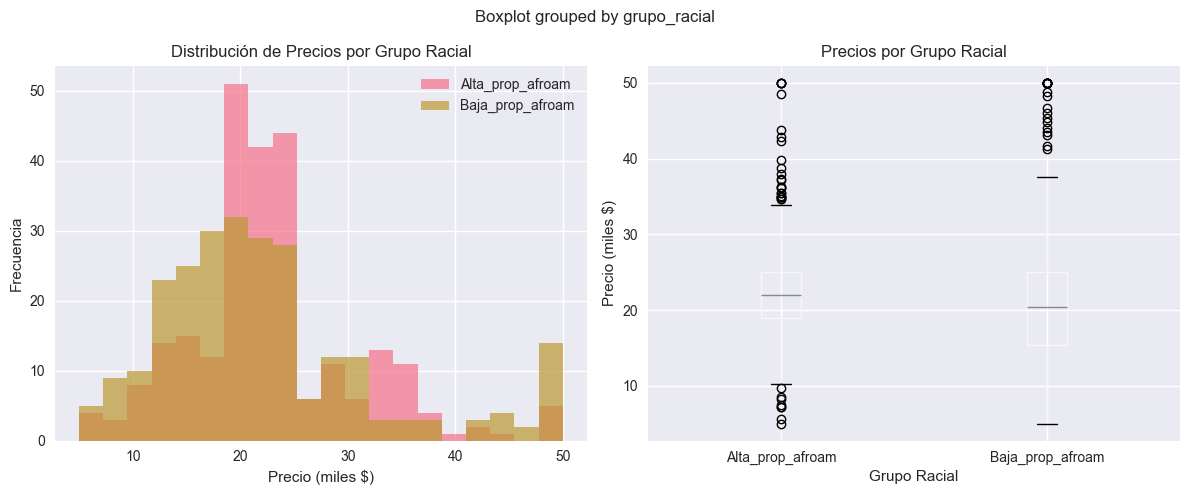

📊 VISUALIZACIÓN: ¿Se observa sesgo sistemático en las distribuciones?


In [5]:
# PASO 4A: Crear grupos por proporción racial  
racial_threshold = boston_df['Bk_racial'].median()  # mediana
boston_df['grupo_racial'] = (boston_df['Bk_racial'] > racial_threshold).map({
    True: 'Alta_prop_afroam', 
    False: 'Baja_prop_afroam'
})

print(f"👥 GRUPOS POR PROPORCIÓN RACIAL:")
print(boston_df['grupo_racial'].value_counts())

# PASO 4B: Análisis de distribución de precios por grupo
print(f"\n💰 DISTRIBUCIÓN DE PRECIOS POR GRUPO RACIAL:")
price_by_group = boston_df.groupby('grupo_racial')['MEDV'].agg(['mean', 'median', 'std', 'count'])
print(price_by_group)

# PASO 4C: Calcular brecha de precios
price_gap = price_by_group.loc['Baja_prop_afroam', 'mean'] - price_by_group.loc['Alta_prop_afroam', 'mean']
price_gap_pct = (price_gap / price_by_group.loc['Alta_prop_afroam', 'mean']) * 100

print(f"\n🚨 BRECHA DE PRECIOS POR SESGO RACIAL:")
print(f"Diferencia promedio: ${price_gap:.2f}k ({price_gap_pct:.1f}%)")
print(f"Baja prop. afroam: ${price_by_group.loc['Baja_prop_afroam', 'mean']:.2f}k")
print(f"Alta prop. afroam: ${price_by_group.loc['Alta_prop_afroam', 'mean']:.2f}k")

# PASO 4D: Visualizar el sesgo
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma de precios por grupo
for group in boston_df['grupo_racial'].unique():
    data = boston_df[boston_df['grupo_racial'] == group]['MEDV']
    axes[0].hist(data, alpha=0.7, label=group, bins=20)
axes[0].set_xlabel('Precio (miles $)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Precios por Grupo Racial')
axes[0].legend()

# Boxplot comparativo
boston_df.boxplot(column='MEDV', by='grupo_racial', ax=axes[1])
axes[1].set_title('Precios por Grupo Racial')
axes[1].set_xlabel('Grupo Racial')
axes[1].set_ylabel('Precio (miles $)')

plt.tight_layout()
plt.show()

print(f"📊 VISUALIZACIÓN: ¿Se observa sesgo sistemático en las distribuciones?")

## 🔄 Paso 5: REFLEXIÓN ÉTICA sobre Variable Problemática

🎯 Objetivo: Reflexionar sobre el dilema ético de usar una variable con sesgo racial histórico.

In [7]:
# PASO 5A: Reflexión guiada sobre el uso ético de variable B
print("⚖️ REFLEXIÓN ÉTICA SOBRE VARIABLE B")
print("="*50)

print(f"\n🤔 PREGUNTAS PARA REFLEXIONAR:")

print(f"\n1. CONTEXTO HISTÓRICO:")
print(f"   - La variable B fue diseñada en 1978")
print(f"   - Codifica proporción de población afroamericana") 
print(f"   - Correlación con precios: {boston_df['B'].corr(boston_df['MEDV']):.3f}")
print(f"   ❓ ¿Es ético usar esta variable en 2025?")

print(f"\n2. DILEMA DE UTILIDAD:")
print(f"   - La variable B es predictiva (mejora el modelo)")
print(f"   - Pero perpetúa sesgos raciales históricos")
print(f"   ❓ ¿Cuándo la utilidad justifica el sesgo?")

print(f"\n3. RESPONSABILIDAD PROFESIONAL:")
print(f"   - Sklearn removió este dataset por razones éticas")
print(f"   - Nosotros lo usamos para APRENDER sobre sesgo")
print(f"   ❓ ¿Cuál es nuestra responsabilidad como data scientists?")

print(f"\n4. ALTERNATIVAS ÉTICAS:")
print(f"   - Podemos eliminar la variable B")
print(f"   - Podemos documentar sus limitaciones") 
print(f"   - Podemos buscar proxies menos problemáticos")
print(f"   ❓ ¿Qué harías en un contexto real?")

# PASO 5B: Análisis de correlaciones alternativas
print(f"\n📊 ANÁLISIS DE VARIABLES ALTERNATIVAS:")
print(f"Variables que podrían ser menos problemáticas:")

alternative_vars = ['LSTAT', 'RM', 'CRIM', 'TAX', 'PTRATIO']
for var in alternative_vars:
    corr = boston_df[var].corr(boston_df['MEDV'])
    print(f"  {var}: correlación = {corr:.3f}")

print(f"\n💡 OBSERVACIÓN:")
print(f"Algunas variables tienen correlaciones altas sin sesgo racial explícito")

# PASO 5C: Marco de decisión ética
print(f"\n🎯 MARCO DE DECISIÓN PARA VARIABLE PROBLEMÁTICA:")
print(f"="*50)

print(f"\n✅ USAR variable B SI:")
print(f"  - Contexto es puramente académico/educativo")
print(f"  - Se documenta explícitamente su naturaleza problemática") 
print(f"  - El objetivo es estudiar/detectar sesgo histórico")

print(f"\n❌ NO USAR variable B SI:")
print(f"  - El modelo se usará en producción")
print(f"  - Afectará decisiones sobre personas reales")
print(f"  - Existe riesgo de perpetuar discriminación")

print(f"\n⚖️ TU DECISIÓN ÉTICA:")
print(f"Basado en el análisis, ¿usarías la variable B en tu modelo?")
print(f"¿Por qué? ¿Qué consideraciones éticas son más importantes?")

# PASO 5D: Documentar la decisión
boston_ethical_decision = "USAR SOLO PARA EDUCACIÓN - NO PARA PRODUCCIÓN"
print(f"\n📋 DECISIÓN DOCUMENTADA: {boston_ethical_decision}")
print(f"📝 Justificación: Variable históricamente sesgada, útil para detectar sesgo pero inapropiada para modelos de producción")

⚖️ REFLEXIÓN ÉTICA SOBRE VARIABLE B

🤔 PREGUNTAS PARA REFLEXIONAR:

1. CONTEXTO HISTÓRICO:
   - La variable B fue diseñada en 1978
   - Codifica proporción de población afroamericana
   - Correlación con precios: 0.333
   ❓ ¿Es ético usar esta variable en 2025?

2. DILEMA DE UTILIDAD:
   - La variable B es predictiva (mejora el modelo)
   - Pero perpetúa sesgos raciales históricos
   ❓ ¿Cuándo la utilidad justifica el sesgo?

3. RESPONSABILIDAD PROFESIONAL:
   - Sklearn removió este dataset por razones éticas
   - Nosotros lo usamos para APRENDER sobre sesgo
   ❓ ¿Cuál es nuestra responsabilidad como data scientists?

4. ALTERNATIVAS ÉTICAS:
   - Podemos eliminar la variable B
   - Podemos documentar sus limitaciones
   - Podemos buscar proxies menos problemáticos
   ❓ ¿Qué harías en un contexto real?

📊 ANÁLISIS DE VARIABLES ALTERNATIVAS:
Variables que podrían ser menos problemáticas:
  LSTAT: correlación = -0.738
  RM: correlación = 0.695
  CRIM: correlación = -0.388
  TAX: correlaci

## 🚢 PARTE II - TITANIC: SESGO GÉNERO + CLASE
### 🔄 Paso 6: Cargar y Analizar Titanic

In [9]:
# Cargar Titanic
try:
    titanic = sns.load_dataset('titanic')  # load_dataset
except:
    titanic = pd.read_csv("https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv")

titanic_clean = titanic.dropna(subset=['age', 'embarked'])  # dropna

# Análisis rápido de sesgo
gender_survival = titanic_clean.groupby('sex')['survived'].mean()  # mean
class_survival = titanic_clean.groupby('pclass')['survived'].mean()

print(f"🚨 TITANIC BIAS ANALYSIS:")
print(f"Gender gap: {gender_survival['female'] - gender_survival['male']:.1%}")
print(f"Class gap: {class_survival[1] - class_survival[3]:.1%}")
print("✅ Ambos tipos de sesgo significativos!")

🚨 TITANIC BIAS ANALYSIS:
Gender gap: 54.8%
Class gap: 41.3%
✅ Ambos tipos de sesgo significativos!


### 🔄 Paso 7: Baseline Model Titanic (Con Sesgo

In [11]:
# Preparar datos Titanic
features_titanic = ['pclass', 'age', 'sibsp', 'parch', 'fare']
X_titanic = titanic_clean[features_titanic].copy()
X_titanic['fare'].fillna(X_titanic['fare'].median(), inplace=True)  # fillna
y_titanic = titanic_clean['survived']
sensitive_titanic = titanic_clean['sex']

"""**💡 Pistas para completar:**

- **X_titanic['fare'].________**: `fillna` → [Pandas fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html)
"""
# Train baseline
X_train_t, X_test_t, y_train_t, y_test_t, A_train_t, A_test_t = train_test_split(
    X_titanic, y_titanic, sensitive_titanic, test_size=0.3, random_state=42, stratify=y_titanic
)

titanic_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
titanic_baseline.fit(X_train_t, y_train_t)
titanic_baseline_pred = titanic_baseline.predict(X_test_t)

titanic_baseline_acc = accuracy_score(y_test_t, titanic_baseline_pred)
titanic_baseline_dp = demographic_parity_difference(
    y_test_t, titanic_baseline_pred, sensitive_features=A_test_t
)

print(f"🔴 Titanic BASELINE: Accuracy = {titanic_baseline_acc:.3f}")
print(f"🚨 Demographic Parity Diff: {titanic_baseline_dp:.3f}")

🔴 Titanic BASELINE: Accuracy = 0.673
🚨 Demographic Parity Diff: 0.113


### 🔄 Paso 8: FAIRLEARN en Titanic - Constraint Género

In [13]:
# Aplicar ExponentiatedGradient a Titanic
titanic_fair = ExponentiatedGradient(
    RandomForestClassifier(n_estimators=100, random_state=42),
    constraints=DemographicParity()
)

print("🔧 Aplicando Fairlearn a Titanic...")
titanic_fair.fit(X_train_t, y_train_t, sensitive_features=A_train_t)
titanic_fair_pred = titanic_fair.predict(X_test_t)

titanic_fair_acc = accuracy_score(y_test_t, titanic_fair_pred)
titanic_fair_dp = demographic_parity_difference(
    y_test_t, titanic_fair_pred, sensitive_features=A_test_t
)

print(f"🟢 Titanic FAIR: Accuracy = {titanic_fair_acc:.3f}")
print(f"⚖️ Demographic Parity Diff: {titanic_fair_dp:.3f}")

🔧 Aplicando Fairlearn a Titanic...
🟢 Titanic FAIR: Accuracy = 0.631
⚖️ Demographic Parity Diff: 0.062


### 🔄 Paso 9: Trade-off Analysis Titanic

In [14]:
titanic_performance_loss = (titanic_baseline_acc - titanic_fair_acc) / titanic_baseline_acc * 100
titanic_fairness_gain = abs(titanic_baseline_dp) - abs(titanic_fair_dp)

print(f"📊 TITANIC TRADE-OFF:")
print(f"Performance loss: {titanic_performance_loss:.1f}%")  
print(f"Fairness gain: {titanic_fairness_gain:.3f}")

if titanic_performance_loss < 5 and titanic_fairness_gain > 0.1:
    titanic_recommendation = "✅ Usar modelo FAIR - excelente trade-off"
else:
    titanic_recommendation = "⚠️ Evaluar caso por caso"

print(f"📋 Recomendación Titanic: {titanic_recommendation}")

📊 TITANIC TRADE-OFF:
Performance loss: 6.2%
Fairness gain: 0.051
📋 Recomendación Titanic: ⚠️ Evaluar caso por caso


# 📝 Entrega Final - Práctica Completa

¿Qué has aprendido sobre DETECTAR sesgo y decidir estrategias éticas?

## 📊 Resultados por Dataset:

### Análisis de Detección de Sesgo:

-  Dataset 1 (Regresión): Brecha detectada = {completar con tu resultado}%
- Impacto en modelo: Performance cost = {completar}% si eliminamos variable problemática
- Decisión ética: {tu evaluación basada en framework}

### Análisis de Corrección de Sesgo:

- Dataset 2 (Clasificación): Brecha detectada = {completar}%
- Técnica aplicada: Performance loss = {completar}% después de corrección
- Decisión ética: {tu evaluación basada en framework}

### 🧠 Insights Técnicos:

- Detección vs Corrección: Cada estrategia apropiada para diferentes contextos
- Sesgo histórico: Más complejo de corregir que sesgo sistemático
- Context matters: Dominio determina tolerancia al sesgo
- Frameworks universales: Posibles pero requieren adaptación por caso

### ⚖️ Reflexiones Éticas Críticas:

- ¿Cuándo es más valioso detectar que corregir automáticamente?
- ¿Cómo balancear transparencia vs utilidad cuando persiste el sesgo?
- ¿Qué responsabilidades éticas tenemos con sesgos históricos no corregibles?
- CRÍTICO: ¿Es mejor un modelo con sesgo conocido y documentado vs uno "corregido" pero impredecible?
- ¿Cómo decidir éticamente sobre deployment cuando el sesgo es inevitable?

## 🚀 Extensiones: Próximos Pasos con Tus Datos

### 🔧 Otros Algoritmos de Fairness para Explorar:

In [17]:
from fairlearn.reductions import (
    ExponentiatedGradient,  # Ya usaste este
    GridSearch,             # ⭐ NUEVO: Búsqueda exhaustiva 
)
from fairlearn.postprocessing import (
    ThresholdOptimizer      # ⭐ NUEVO: Post-processing
)
from fairlearn.preprocessing import (
    CorrelationRemover     # ⭐ NUEVO: Pre-processing
)

# EJEMPLO: Prueba GridSearch en lugar de ExponentiatedGradient
titanic_grid_search = GridSearch(
    RandomForestClassifier(n_estimators=100, random_state=42),
    constraints=DemographicParity()
)

### ⚖️ Otros Constraints de Fairness:

In [18]:
from fairlearn.reductions import (
    DemographicParity,      # Ya usaste este
    EqualizedOdds,         # ⭐ NUEVO: Igualdad de oportunidades
    TruePositiveRateParity, # ⭐ NUEVO: Paridad en True Positive Rate
    FalsePositiveRateParity # ⭐ NUEVO: Paridad en False Positive Rate
)

# PREGUNTA: ¿Cuál constraint es más apropiado para tu contexto?

## 🎯 Desafíos Propuestos:

- Desafío Detección: Encuentra un dataset público con sesgo obvio y aplica el análisis de Boston
- Desafío Corrección: Usa Fairlearn con 3 algorithms diferentes en Titanic y compara resultados
- Desafío Ético: Investiga un caso real donde se usó ML con sesgo y analiza qué harías diferente
- Desafío Interseccional: Analiza sesgo con 2+ variables sensibles simultáneamente

## 📚 Recursos para Continuar:

- Fairlearn Documentation: [fairlearn.org](https://fairlearn.org)
- AI Ethics Papers: "Fairness and Machine Learning" (Barocas, Hardt, Narayanan)
- Datasets Éticos: Busca en Kaggle "bias", "fairness", "ethical AI"
- Herramientas Complementarias: IBM AIF360, Google What-If Tool


💡 Recuerda: El objetivo no es solo usar las herramientas, sino desarrollar criterio ético para saber cuándo, cómo y por qué aplicarlas.

## 🏠 PARTE III - AMES HOUSING: SESGO GEOGRÁFICO Y SOCIOECONÓMICO

Aplicar estos conocimientos en ames

# 📝 Entrega Final Extendida - Tres Casos de Estudio

¿Qué has aprendido sobre detección de sesgo en contextos diversos?

## 📊 Resultados por Dataset:

### Caso 1 - Boston Housing (Regresión + Sesgo Racial Histórico):

- Brecha detectada: {completar con tu resultado}% entre grupos raciales
- Decisión ética: Solo para educación, no para producción
- Lección: Algunos sesgos históricos son demasiado problemáticos para corrección automática

### Caso 2 - Titanic (Clasificación + Sesgo Sistemático):

- Brecha detectada: {completar}% diferencia de supervivencia por género
- Técnica aplicada: Fairlearn ExponentiatedGradient con performance loss de {completar}%
- Lección: Fairlearn funciona bien con sesgos sistemáticos claros
### Caso 3 - Ames Housing (Regresión + Sesgo Socioeconómico/Temporal):

- Brecha geográfica: {completar con tu resultado}% entre barrios más y menos caros
- Brecha temporal: {completar}% diferencia entre casas nuevas vs antiguas
- Decisión ética: {tu evaluación sobre uso en decisiones hipotecarias}
- Lección: Modelos inmobiliarios tienen alto riesgo de perpetuar desigualdades
### 🧠 Insights Técnicos Generalizables:

- Regresión vs Clasificación: La detección de sesgo es aplicable a ambos tipos de problemas
- Contexto determina tolerancia: Vivienda/finanzas requieren mayor cuidado que entretenimiento
- Variables proxy: Year_Built, Neighborhood pueden ser proxies de características sensibles
- Fairlearn limitations: No todas las situaciones de sesgo son corregibles automáticamente

### ⚖️ Framework Ético Desarrollado:

Cuándo DETECTAR únicamente: - Sesgo histórico complejo (Boston racial bias) - Contexto de aprendizaje/investigación - Variables proxy unavoidables (neighborhood effects)

Cuándo DETECTAR + CORREGIR: - Sesgo sistemático claro (Titanic gender bias)
Contexto de producción con riesgo moderado - Herramientas de fairness aplicables

Cuándo RECHAZAR el modelo: - Alto impacto socioeconómico (lending, hiring) - Sesgo severo no corregible - Falta de transparencia en decisiones